# 料理の画像からアレルゲンを抽出

まず、`import`の手順を行う。実際実装したところ、<br>
`from keras import ...`を実行する時点においては、<br>
パッケージのバージョンの違いが観測され、<br>
独立した`keras`から`import`することになった。

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import tensorflow as tf
from keras import datasets, layers, models, losses, regularizers
from keras.api.optimizers import Adam
from keras.api.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.api.utils import plot_model

import tensorflow_datasets as tfds

AUTOTUNE = tf.data.experimental.AUTOTUNE

2025-05-17 02:30:37.121789: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 02:30:37.129724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747416637.140773    5160 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747416637.143965    5160 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747416637.152038    5160 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

次に素材を導入する。ただし、ディレクトリを確認し、<br>
分類が正しく認識されているかチェックすること。<br>
出力から見ると、写真が正しく利用可能になった。

In [2]:
# Load local food-101 dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'/home/jdh/UOsaka/b2_cv_lab/food-101/images',
    image_size=(224, 224),
    batch_size=16,
    shuffle=True,
    label_mode="categorical",
    seed=123,
    validation_split=0.2,
    subset="training"
)

class_names = train_dataset.class_names
num_classes = len(class_names)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'/home/jdh/UOsaka/b2_cv_lab/food-101/images',
    image_size=(224, 224),
    batch_size=16,
    shuffle=False,
    label_mode="categorical",
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 101000 files belonging to 101 classes.
Using 80800 files for training.


I0000 00:00:1747416640.795456    5160 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9502 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 101000 files belonging to 101 classes.
Using 20200 files for validation.


次に中間層を決める。試行を重ねた結果、<br>
中間層の構造及び学習率の設定が以下の通りになった。

In [3]:
# Build a simple CNN model
model = models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    layers.Rescaling(1./255),

    # Block 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(),

    # Block 4
    layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.3),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.25),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.25),

    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

残りは学習させること。毎回の試行の結果を可視化するために、<br>
`Accuracy`と`Loss`を図示した。

Epoch 1/30


I0000 00:00:1747416645.936467    5300 service.cc:152] XLA service 0x7f4bd801e090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747416645.936494    5300 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-05-17 02:30:45.993687: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747416646.301560    5300 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-17 02:30:47.184384: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3428', 432 bytes spill stores, 432 bytes spill loads

2025-05-17 02:30:47.218314: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_

   2/5050 ━━━━━━━━━━━━━━━━━━━━ 6:19 75ms/step - accuracy: 0.0000e+00 - loss: 7.3026 

I0000 00:00:1747416650.930699    5300 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5050/5050 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0190 - loss: 4.8514

2025-05-17 02:33:08.678292: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_330', 52 bytes spill stores, 52 bytes spill loads

2025-05-17 02:33:20.078998: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_330', 64 bytes spill stores, 64 bytes spill loads



5050/5050 ━━━━━━━━━━━━━━━━━━━━ 156s 29ms/step - accuracy: 0.0190 - loss: 4.8514 - val_accuracy: 0.0650 - val_loss: 4.6399 - learning_rate: 1.0000e-04
Epoch 2/30
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 147s 29ms/step - accuracy: 0.0271 - loss: 4.6566 - val_accuracy: 0.0596 - val_loss: 4.4554 - learning_rate: 1.0000e-04
Epoch 3/30
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 143s 28ms/step - accuracy: 0.0436 - loss: 4.4586 - val_accuracy: 0.1548 - val_loss: 3.9253 - learning_rate: 1.0000e-04
Epoch 4/30
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 193s 38ms/step - accuracy: 0.0784 - loss: 4.1478 - val_accuracy: 0.1964 - val_loss: 3.6241 - learning_rate: 1.0000e-04
Epoch 5/30
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 149s 29ms/step - accuracy: 0.1294 - loss: 3.8220 - val_accuracy: 0.2459 - val_loss: 3.2277 - learning_rate: 1.0000e-04
Epoch 6/30
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 190s 38ms/step - accuracy: 0.1762 - loss: 3.5504 - val_accuracy: 0.3000 - val_loss: 2.9700 - learning_rate: 1.0000e-04
Epoch 7/30
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 320

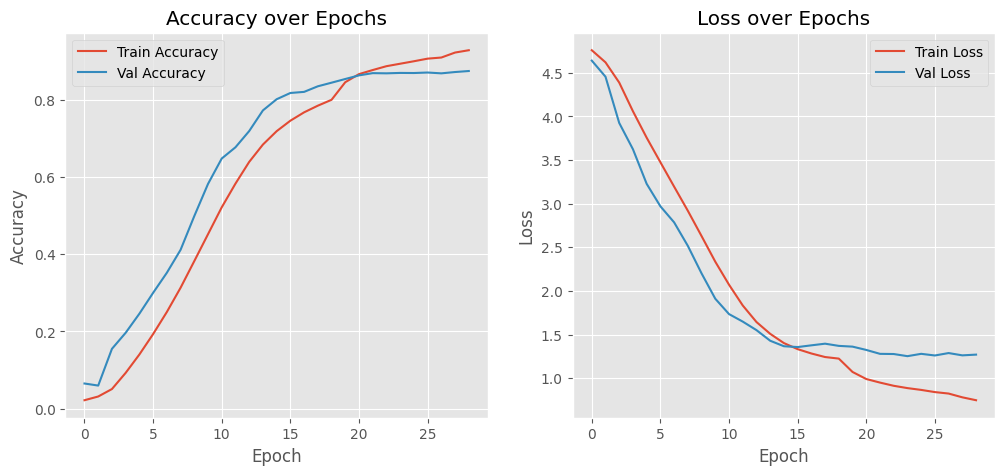

In [4]:
# Train the model
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=callbacks
)

# Save the model
model.save('food-101_model.keras')
print("✅ Training complete, model saved as 'food-101_model.keras'!")

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()